In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

import imageio
from skimage.transform import resize
import random

SEED = 34

In [3]:
import os
import zipfile
import requests

### 사전 저장된 celeba small 데이터 불러오기

In [4]:
data=np.load('./celeba_small.npz')

In [5]:
list(data.keys())

['train_images', 'train_labels', 'test_images', 'test_labels']

In [7]:
data['train_labels'][0]

array([0, 0], dtype=int8)

In [8]:
data['train_images'][0].shape

(72, 59, 3)

In [9]:
data['train_labels'][0].shape

(2,)

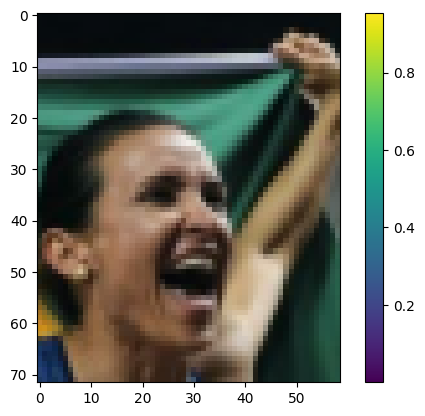

In [10]:
# x를 plt를 이용하여 출력하는 코드를 작성해보세요
plt.imshow(data['train_images'][0])
plt.colorbar()
plt.show()

In [11]:
# data split
train_images=data['train_images']
train_labels=data['train_labels']

test_images=data['test_images']
test_labels=data['test_labels']

In [12]:
print(len(train_images))
print(len(train_labels))
print(train_images.shape)
print(train_labels.shape)
print(train_images[0].shape)
print(train_labels[0].shape)

2000
2000
(2000, 72, 59, 3)
(2000, 2)
(72, 59, 3)
(2,)


In [13]:
#남자 여자 빈도수 알아보기
Male=0
Female=0
Smile=0
N_Smile=0
for i in train_labels:
    if i[0]==0:
        Female+=1
    if i[0]==1:
        Male+=1
    if i[1]==0:
        N_Smile+=1
    if i[1]==1:
        Smile+=1

In [14]:
print(Male)
print(Female)
print(Smile)
print(N_Smile)

994
1006
997
1003


In [15]:
from keras.utils import to_categorical

In [16]:
train_male_labels, train_smile_labels=np.split(train_labels,2,axis=1)

In [85]:
train_labels

array([[0, 0],
       [1, 1],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int8)

In [17]:
test_male_labels, test_smile_labels=np.split(test_labels,2,axis=1)

In [18]:
# One Hot encoding

train_male_labels=to_categorical(train_male_labels)
train_smile_labels=to_categorical(train_smile_labels)

In [19]:
test_male_labels=to_categorical(test_male_labels)
test_smile_labels=to_categorical(test_smile_labels)

In [20]:
print(train_male_labels[0].shape)
print(train_smile_labels[0].shape)
print(test_male_labels[0].shape)
print(test_smile_labels[0].shape)

(2,)
(2,)
(2,)
(2,)


In [21]:
# 라벨링 데이터 차원 합쳐주기
train_labels2=np.concatenate([train_male_labels,train_smile_labels],axis=1)
test_labels2=np.concatenate([test_male_labels,test_smile_labels],axis=1)

In [22]:
# shape 확인
print(train_labels2.shape)
print(test_labels2.shape)

(2000, 4)
(200, 4)


In [23]:
train_images.shape

(2000, 72, 59, 3)

In [24]:
train_images[:5].shape #batch_size, height, width, channel순

(5, 72, 59, 3)

In [25]:
np.hstack(train_images[:5]).shape

(72, 295, 3)

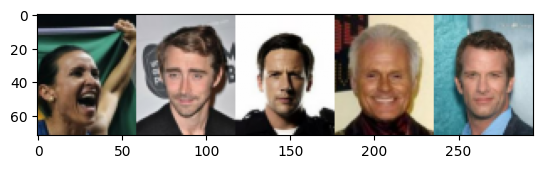

[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 1.]]


In [26]:
plt.imshow(np.hstack(train_images[:5]))
plt.show()
print(train_labels2[:5])

In [27]:
# 이미지 행렬 전치

In [28]:
train_images[:5].transpose((1,0,2,3)).reshape(72,-1,3).shape #height, batch_size, width, channel=> reshape으로 batch_size와 width를 합쳐줌

(72, 295, 3)

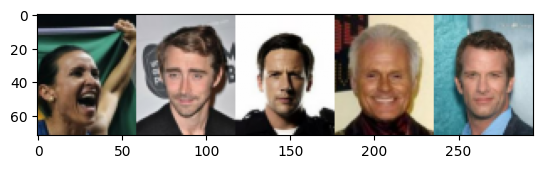

In [29]:
plt.imshow(train_images[:5].transpose((1,0,2,3)).reshape(72,-1,3))

In [30]:
train_labels2[:5]

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.]], dtype=float32)

In [31]:
for male, smile in zip(train_male_labels[:5],train_smile_labels[:5]):
    print(male,smile)

[1. 0.] [1. 0.]
[0. 1.] [0. 1.]
[0. 1.] [1. 0.]
[0. 1.] [0. 1.]
[0. 1.] [0. 1.]


In [32]:
train_labels

array([[0, 0],
       [1, 1],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int8)

In [33]:
# smile,male 분포 확인

df=pd.DataFrame(train_labels,columns=['gender','smile'])

<AxesSubplot:xlabel='gender'>

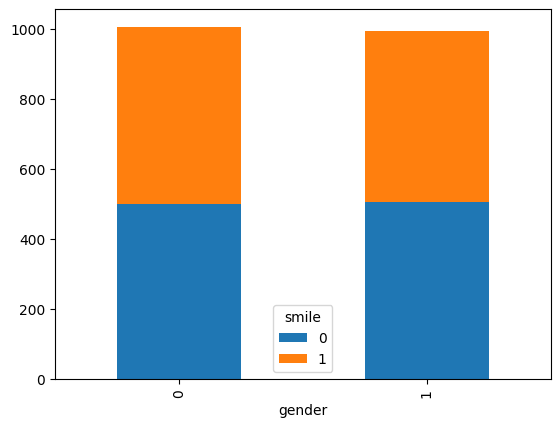

In [34]:
df.groupby(['gender','smile']).size().unstack().plot(kind='bar',stacked=True)

<AxesSubplot:xlabel='gender'>

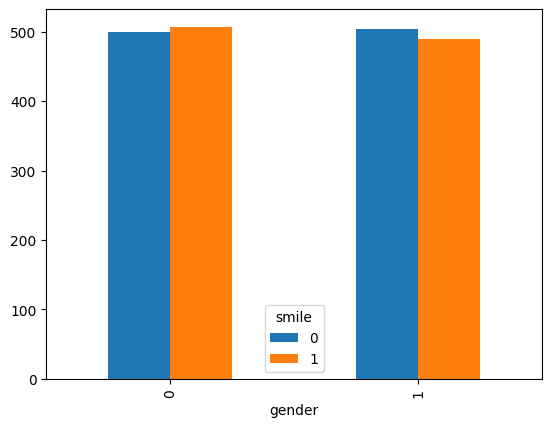

In [36]:
df.groupby(['gender','smile']).size().unstack().plot(kind='bar',stacked=False)

# 모델링

In [47]:
print(train_labels[0]) #여자, 웃지않음
print(train_labels[0].shape)
print(train_labels2[0]) #One Hot Encoding변경->앞쪽이=1->여자, 3번째=1->웃지않는것
print(train_labels2[0].shape)

[0 0]
(2,)
[1. 0. 1. 0.]
(4,)


In [226]:
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Input, Flatten, Concatenate, BatchNormalization

In [124]:
def img_class_model():
    inputs=Input((72,59,3))
    x=Conv2D(32,3,activation='relu')(inputs) #Conv2D(output_channels수, kernel_size,stride,activation)
    x=MaxPool2D(2)(x) #이미지 크기 줄여주기
    x=Conv2D(64,3,activation='relu')(x) #채널 64개로 증가
    x=MaxPool2D(2)(x) #다시한번 이미지 크기 줄여주기
    x=Conv2D(64,3,activation='relu')(x) #한번더 Convolution
    #x=MaxPool2D(2)(x) #다시한번 이미지 크기 줄여주기
    x=Conv2D(128,3,activation='relu')(x) #한번더 Convolution
    x=Flatten()(x) #1차원 백터로 이미지 데이터 변환, 정보 유지하면서 fully connected에 넘겨줌=>평평하게만 만듬
    x=Dense(64,activation='relu')(x) #모든 입력 뉴런과 출력 뉴런이 서로 완전히 연결된 신경망
    outputs=Dense(2,activation='softmax')(x) #가장 예측값이 높은 클래스 추출
    
    model=Model(inputs,outputs) #입력 출력 입력
    return model

In [125]:
gender_model=img_class_model()
smile_model=img_class_model()

In [126]:
gender_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 72, 59, 3)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 70, 57, 32)        896       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 35, 28, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 33, 26, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 16, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 14, 11, 64)        369

In [127]:
gender_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
smile_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [128]:
gender_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 72, 59, 3)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 70, 57, 32)        896       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 35, 28, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 33, 26, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 16, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 14, 11, 64)        369

In [129]:
gender_hist=gender_model.fit(train_images,train_male_labels,validation_data=(test_images,test_male_labels),epochs=15,verbose=1)

Epoch 1/15
63/63 [==============================] - 2s 14ms/step - loss: 0.5915 - accuracy: 0.6710 - val_loss: 0.5347 - val_accuracy: 0.7750
Epoch 2/15
63/63 [==============================] - 1s 11ms/step - loss: 0.4528 - accuracy: 0.8005 - val_loss: 0.4181 - val_accuracy: 0.8200
Epoch 3/15
63/63 [==============================] - 1s 11ms/step - loss: 0.3346 - accuracy: 0.8610 - val_loss: 0.3453 - val_accuracy: 0.8750
Epoch 4/15
63/63 [==============================] - 1s 11ms/step - loss: 0.2652 - accuracy: 0.8940 - val_loss: 0.3489 - val_accuracy: 0.8850
Epoch 5/15
63/63 [==============================] - 1s 11ms/step - loss: 0.1821 - accuracy: 0.9295 - val_loss: 0.3087 - val_accuracy: 0.8750
Epoch 6/15
63/63 [==============================] - 1s 11ms/step - loss: 0.1521 - accuracy: 0.9420 - val_loss: 0.2412 - val_accuracy: 0.9000
Epoch 7/15
63/63 [==============================] - 1s 11ms/step - loss: 0.1171 - accuracy: 0.9600 - val_loss: 0.2359 - val_accuracy: 0.9100
Epoch 8/15
63

In [130]:
smile_hist=smile_model.fit(train_images,train_smile_labels,validation_data=(test_images,test_smile_labels),epochs=15,verbose=1)

Epoch 1/15
63/63 [==============================] - 1s 13ms/step - loss: 0.7079 - accuracy: 0.5025 - val_loss: 0.6931 - val_accuracy: 0.4850
Epoch 2/15
63/63 [==============================] - 1s 10ms/step - loss: 0.6949 - accuracy: 0.5090 - val_loss: 0.6921 - val_accuracy: 0.5150
Epoch 3/15
63/63 [==============================] - 1s 11ms/step - loss: 0.6878 - accuracy: 0.5465 - val_loss: 0.6697 - val_accuracy: 0.5550
Epoch 4/15
63/63 [==============================] - 1s 11ms/step - loss: 0.6527 - accuracy: 0.6115 - val_loss: 0.6182 - val_accuracy: 0.6250
Epoch 5/15
63/63 [==============================] - 1s 10ms/step - loss: 0.5757 - accuracy: 0.6980 - val_loss: 0.5014 - val_accuracy: 0.7700
Epoch 6/15
63/63 [==============================] - 1s 11ms/step - loss: 0.4080 - accuracy: 0.8100 - val_loss: 0.2741 - val_accuracy: 0.8950
Epoch 7/15
63/63 [==============================] - 1s 12ms/step - loss: 0.3256 - accuracy: 0.8620 - val_loss: 0.2579 - val_accuracy: 0.9200
Epoch 8/15
63

In [104]:
# loss accuracy 시각화

Text(0.5, 1.0, 'accuracy&Loss')

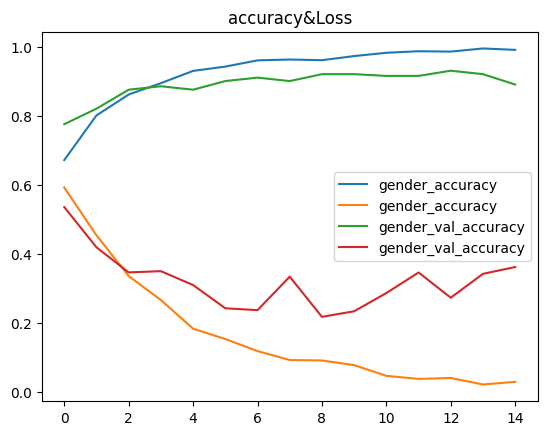

In [131]:
plt.plot(gender_hist.history['accuracy'],label='gender_accuracy')
plt.plot(gender_hist.history['loss'],label='gender_accuracy')
plt.plot(gender_hist.history['val_accuracy'],label='gender_val_accuracy')
plt.plot(gender_hist.history['val_loss'],label='gender_val_accuracy')
plt.legend()
plt.title('accuracy&Loss')

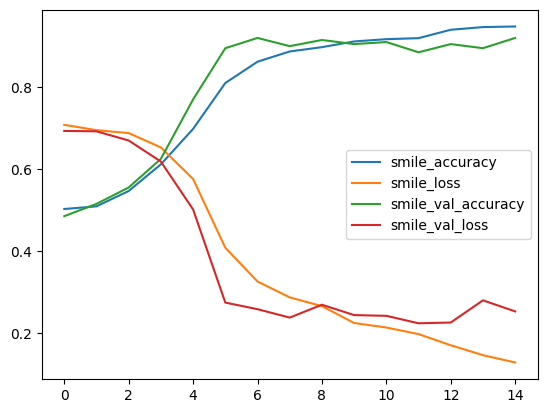

In [132]:
plt.plot(smile_hist.history['accuracy'],label='smile_accuracy')
plt.plot(smile_hist.history['loss'],label='smile_loss')
plt.plot(smile_hist.history['val_accuracy'],label='smile_val_accuracy')
plt.plot(smile_hist.history['val_loss'],label='smile_val_loss')
plt.legend()

# 결과 확인

In [144]:
res=gender_model.predict(test_images[1:2])
res

1/1 [==============================] - 0s 29ms/step


array([[9.9999917e-01, 7.8081240e-07]], dtype=float32)

In [145]:
res_smile=smile_model.predict(test_images[1:2])
res_smile

1/1 [==============================] - 0s 25ms/step


array([[0.8672486, 0.1327514]], dtype=float32)

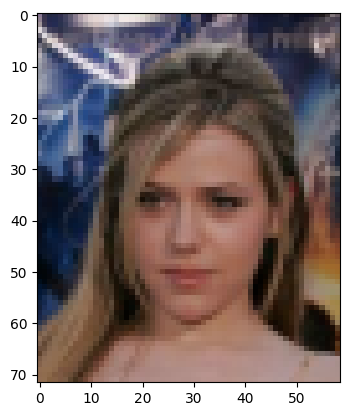

In [147]:
plt.imshow(test_images[1])
plt.show()

<BarContainer object of 2 artists>

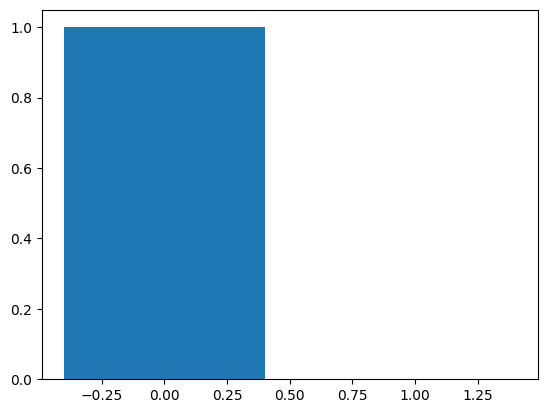

In [148]:
plt.bar(range(2),res[0])

<BarContainer object of 2 artists>

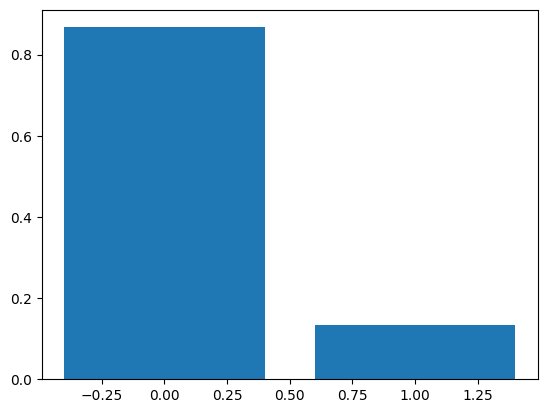

In [149]:
plt.bar(range(2),res_smile[0])

In [150]:
# 성별, 웃음 Multi Modeling

In [227]:
def multi_model():
    inputs=Input((72,59,3))
    
    x=Conv2D(32,3,activation='relu')(inputs) #Conv2D(output_channels수, kernel_size,stride,activation)
    x = BatchNormalization()(x)
    x=MaxPool2D(2)(x) #이미지 크기 줄여주기
    x=Conv2D(64,3,activation='relu')(x) #채널 64개로 증가
    x = BatchNormalization()(x)
    x=MaxPool2D(2)(x) #다시한번 이미지 크기 줄여주기
    x=Conv2D(64,3,activation='relu')(x) #한번더 Convolution
    x = BatchNormalization()(x)
    #x=MaxPool2D(2)(x) #다시한번 이미지 크기 줄여주기
    x=Conv2D(128,3,activation='relu')(x) #한번더 Convolution
    x = BatchNormalization()(x)
    x=Conv2D(256,3,activation='relu')(x)
    x = BatchNormalization()(x)
    x=MaxPool2D(2)(x) #다시한번 이미지 크기 줄여주기
    
    x=Flatten()(x) #1차원 백터로 이미지 데이터 변환, 정보 유지하면서 fully connected에 넘겨줌=>평평하게만 만듬
    x=Dense(64,activation='relu')(x) #모든 입력 뉴런과 출력 뉴런이 서로 완전히 연결된 신경망
    gender_outputs=Dense(2,activation='softmax')(x) #가장 예측값이 높은 클래스 추출
    smile_outputs=Dense(2,activation='softmax')(x) #가장 예측값이 높은 클래스 추출
    
    outputs=Concatenate(axis=1)([gender_outputs,smile_outputs]) #라벨링 데이터 행방향 합쳐주기
    model=Model(inputs,outputs) #입력 출력 입력
    return model

In [228]:
multi_class_model=multi_model()

In [229]:
multi_class_model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 72, 59, 3)]  0           []                               
                                                                                                  
 conv2d_81 (Conv2D)             (None, 70, 57, 32)   896         ['input_25[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 70, 57, 32)  128         ['conv2d_81[0][0]']              
 alization)                                                                                       
                                                                                                  
 max_pooling2d_53 (MaxPooling2D  (None, 35, 28, 32)  0           ['batch_normalization[0][0

In [230]:
multi_class_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [231]:
model_hist1=multi_class_model.fit(train_images,train_labels2,validation_data=(test_images,test_labels2),epochs=20,verbose=1)

Epoch 1/20
63/63 [==============================] - 2s 24ms/step - loss: 2.7635 - accuracy: 0.2895 - val_loss: 6.6523 - val_accuracy: 0.0000e+00
Epoch 2/20
63/63 [==============================] - 1s 15ms/step - loss: 2.0836 - accuracy: 0.4500 - val_loss: 7.7066 - val_accuracy: 0.0000e+00
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 1.8380 - accuracy: 0.5430 - val_loss: 3.3071 - val_accuracy: 0.1300
Epoch 4/20
63/63 [==============================] - 1s 15ms/step - loss: 1.6800 - accuracy: 0.5640 - val_loss: 2.6578 - val_accuracy: 0.3600
Epoch 5/20
63/63 [==============================] - 1s 15ms/step - loss: 1.5392 - accuracy: 0.6025 - val_loss: 2.6258 - val_accuracy: 0.4100
Epoch 6/20
63/63 [==============================] - 1s 15ms/step - loss: 1.4733 - accuracy: 0.6225 - val_loss: 2.0136 - val_accuracy: 0.5150
Epoch 7/20
63/63 [==============================] - 1s 15ms/step - loss: 1.4341 - accuracy: 0.6020 - val_loss: 2.1096 - val_accuracy: 0.5050
Epoch

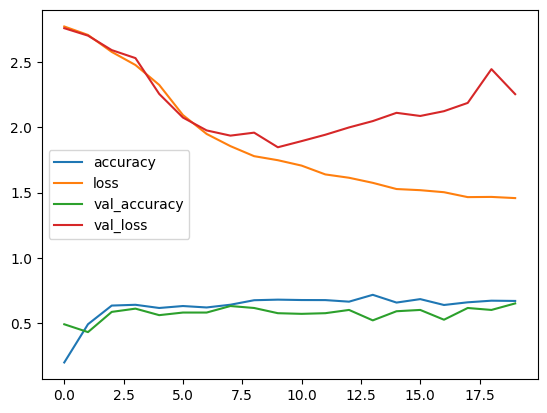

In [216]:
plt.plot(model_hist1.history['accuracy'],label='accuracy')
plt.plot(model_hist1.history['loss'],label='loss')
plt.plot(model_hist1.history['val_accuracy'],label='val_accuracy')
plt.plot(model_hist1.history['val_loss'],label='val_loss')
plt.legend()

In [218]:
def multi_model2():
    inputs=Input((72,59,3))
    
    x=Conv2D(32,3,activation='relu')(inputs) #Conv2D(output_channels수, kernel_size,stride,activation)
    x=MaxPool2D(2)(x) #이미지 크기 줄여주기
    x=Conv2D(64,3,activation='relu')(x) #채널 64개로 증가
    x=MaxPool2D(2)(x) #다시한번 이미지 크기 줄여주기
    x=Conv2D(64,3,activation='relu')(x) #한번더 Convolution
    #x=MaxPool2D(2)(x) #다시한번 이미지 크기 줄여주기
    x=Conv2D(128,3,activation='relu')(x) #한번더 Convolution
    x=Conv2D(256,3,activation='relu')(x)
    x=MaxPool2D(2)(x) #다시한번 이미지 크기 줄여주기
    
    x=Flatten()(x) #1차원 백터로 이미지 데이터 변환, 정보 유지하면서 fully connected에 넘겨줌=>평평하게만 만듬
    x=Dense(64,activation='relu')(x) #모든 입력 뉴런과 출력 뉴런이 서로 완전히 연결된 신경망
    gender_outputs=Dense(2,activation='softmax')(x) #가장 예측값이 높은 클래스 추출
    smile_outputs=Dense(2,activation='softmax')(x) #가장 예측값이 높은 클래스 추출
    
    #outputs=Concatenate(axis=1)([gender_outputs,smile_outputs]) #라벨링 데이터 행방향 합쳐주기
    model=Model(inputs,[gender_outputs,smile_outputs]) #입력 출력 입력
    return model

In [219]:
model2=multi_model2()

In [220]:
model2.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 72, 59, 3)]  0           []                               
                                                                                                  
 conv2d_76 (Conv2D)             (None, 70, 57, 32)   896         ['input_24[0][0]']               
                                                                                                  
 max_pooling2d_50 (MaxPooling2D  (None, 35, 28, 32)  0           ['conv2d_76[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_77 (Conv2D)             (None, 33, 26, 64)   18496       ['max_pooling2d_50[0][0]']

In [221]:
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_hist2=model2.fit(train_images,[train_male_labels,train_smile_labels],validation_data=(test_images,[test_male_labels,test_smile_labels]),epochs=20,verbose=1)

Epoch 1/20
63/63 [==============================] - 2s 19ms/step - loss: 1.3435 - dense_45_loss: 0.6526 - dense_46_loss: 0.6910 - dense_45_accuracy: 0.6175 - dense_46_accuracy: 0.5225 - val_loss: 1.2774 - val_dense_45_loss: 0.5993 - val_dense_46_loss: 0.6781 - val_dense_45_accuracy: 0.6900 - val_dense_46_accuracy: 0.5600
Epoch 2/20
63/63 [==============================] - 1s 15ms/step - loss: 1.2133 - dense_45_loss: 0.5455 - dense_46_loss: 0.6679 - dense_45_accuracy: 0.7315 - dense_46_accuracy: 0.5930 - val_loss: 1.1453 - val_dense_45_loss: 0.5213 - val_dense_46_loss: 0.6240 - val_dense_45_accuracy: 0.7650 - val_dense_46_accuracy: 0.6350
Epoch 3/20
63/63 [==============================] - 1s 14ms/step - loss: 1.0353 - dense_45_loss: 0.4312 - dense_46_loss: 0.6041 - dense_45_accuracy: 0.8050 - dense_46_accuracy: 0.6785 - val_loss: 0.9550 - val_dense_45_loss: 0.4149 - val_dense_46_loss: 0.5401 - val_dense_45_accuracy: 0.8700 - val_dense_46_accuracy: 0.7400
Epoch 4/20
63/63 [=============

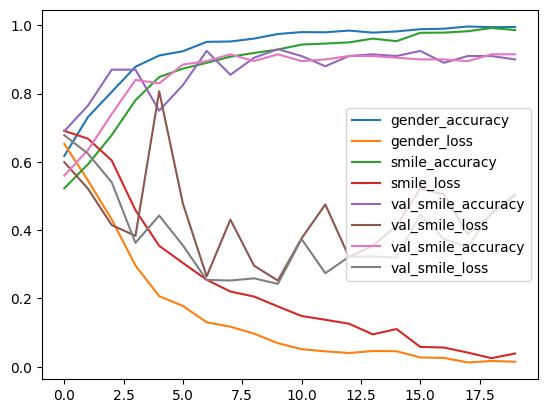

In [225]:
plt.plot(model_hist2.history['dense_45_accuracy'],label='gender_accuracy')
plt.plot(model_hist2.history['dense_45_loss'],label='gender_loss')
plt.plot(model_hist2.history['dense_46_accuracy'],label='smile_accuracy')
plt.plot(model_hist2.history['dense_46_loss'],label='smile_loss')
plt.plot(model_hist2.history['val_dense_45_accuracy'],label='val_smile_accuracy')
plt.plot(model_hist2.history['val_dense_45_loss'],label='val_smile_loss')
plt.plot(model_hist2.history['val_dense_46_accuracy'],label='val_smile_accuracy')
plt.plot(model_hist2.history['val_dense_46_loss'],label='val_smile_loss')
plt.legend()
plt.legend()

In [245]:
# 결과확인
res=model2.predict(test_images[1:2])
res

1/1 [==============================] - 0s 28ms/step


[array([[9.999989e-01, 1.081668e-06]], dtype=float32),
 array([[9.9960071e-01, 3.9932388e-04]], dtype=float32)]

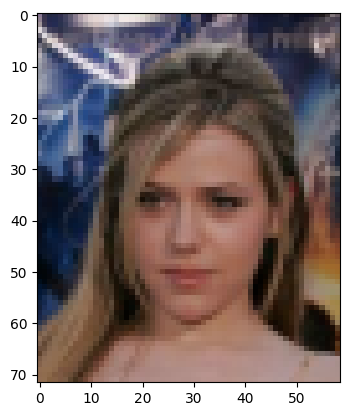

In [246]:
plt.imshow(test_images[1])
plt.show()

In [247]:
res[1][0]

array([9.9960071e-01, 3.9932388e-04], dtype=float32)

<BarContainer object of 2 artists>

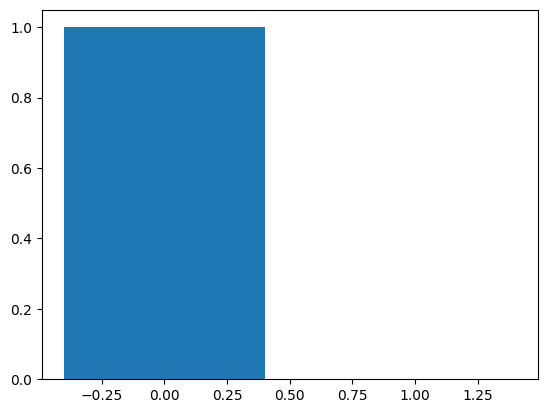

In [248]:
plt.bar(range(2),res[0][0])

<BarContainer object of 2 artists>

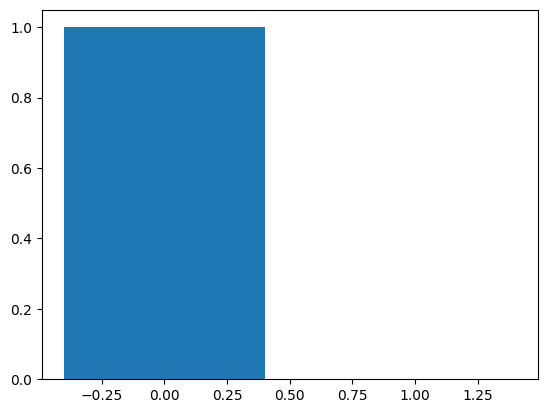

In [249]:
plt.bar(range(2),res[1][0])

In [254]:
# model 분리

In [255]:
model2.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 72, 59, 3)]  0           []                               
                                                                                                  
 conv2d_76 (Conv2D)             (None, 70, 57, 32)   896         ['input_24[0][0]']               
                                                                                                  
 max_pooling2d_50 (MaxPooling2D  (None, 35, 28, 32)  0           ['conv2d_76[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_77 (Conv2D)             (None, 33, 26, 64)   18496       ['max_pooling2d_50[0][0]']

In [266]:
gender_model2=Model(inputs=model2.input,outputs=model2.get_layer('dense_45').output) #성별 모델 분리

In [267]:
gender_model2.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 72, 59, 3)]       0         
                                                                 
 conv2d_76 (Conv2D)          (None, 70, 57, 32)        896       
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 35, 28, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 33, 26, 64)        18496     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 16, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 14, 11, 64)        369

In [268]:
smile_model2=Model(inputs=model2.input,outputs=model2.get_layer('dense_46').output) #성별 모델 분리

In [269]:
smile_model2.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 72, 59, 3)]       0         
                                                                 
 conv2d_76 (Conv2D)          (None, 70, 57, 32)        896       
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 35, 28, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 33, 26, 64)        18496     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 16, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 14, 11, 64)        369

In [271]:
x=gender_model2.predict(test_images[0:1])
x.argmax()

1/1 [==============================] - 0s 24ms/step


1

In [273]:
x=smile_model2.predict(test_images[0:1])
x.argmax()

1/1 [==============================] - 0s 23ms/step


1

In [274]:
# 모델 저장 및 로드

In [275]:
model2.save('./multimodel.h5')

In [277]:
gender_model2.save('./gendermodel.h5')
smile_model2.save('./smilemodel.h5')

In [ ]:
# 모델 로드
model3=tf.keras.models.load_model('./multimodel.h5')